### Importing Libraries

In [34]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

### Instantiating variables to store the title, the body and the stars of every review

In [2]:
review_title = []
review_body = []
review_stars = []
i = 0

### The next cell include the all the various steps of the scraping:
### 1. Creating a variable "URL" with the first review page
### 2. Creating an header to handle request to the website: this is mandatory, otherwise we cannot access the code of a website
### 3. While loop that iterate the first 50 pages. This just to be sure to not exceed the maximum amount of request and being banned
### 4. Inside the while I look for all the css selectors that contains the title, the body and te amount of stars the person gave to the product of the review
### 5. The last part (very important) allow the scraper to change the URL automatically to the next page

In [3]:
URL = "https://www.amazon.it/echo-dot-2022/product-reviews/B09B8X9RGM/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews"

headers = {
        'authority': 'www.amazon.it',
        'user-agent': 'Mozilla/5.0 (X11; CrOS x86_64 8172.45.0) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/51.0.2704.64 Safari/537.36',
        'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
        'accept-language': 'it-IT,it;en-GB,en-US;q=0.9,en;q=0.8',
    }

while i <= 50:
    webpage = requests.get(URL, headers=headers)
    soup = BeautifulSoup(webpage.content, 'html.parser')
    review_title.append(soup.select('a.review-title'))
    review_body.append(soup.select('div.a-row.review-data span.review-text'))
    review_stars.append(soup.select('div.a-row:nth-of-type(2) > a.a-link-normal:nth-of-type(1)'))
    next_url = soup.select_one('li.a-last a').get('href')
    URL = f"https://www.amazon.it{next_url}"
    i += 1


### Here I just adjust the text, removing the "\n" and selecting the number of stars from the various texts

In [4]:
review_title = [[element.text.replace('\n', '') for element in sublist] for sublist in review_title]
review_body = [[element.text.replace('\n', '') for element in sublist] for sublist in review_body]
review_stars = [[element.get('title').split()[0] for element in sublist] for sublist in review_stars]

In [5]:
review_body = [[re.sub(r'[^\w\s,]', ' ', element) for element in sublist] for sublist in review_body] # remove any emojis from the body

In [17]:
# Only checking all the various lenght to be sure that all the list have the same lenght, otherwise I am not able to construct the DatFrame
print(len(review_title))
print(len(review_body))
print(len(review_stars))
print(sum(len(sublist) for sublist in review_title))
print(sum(len(sublist) for sublist in review_body))
print(sum(len(sublist) for sublist in review_stars))

51
51
51
510
510
510


In [9]:
df = pd.DataFrame(columns = ['Title', 'Body', 'Stars'])

In [14]:
df['Title'] = [item for sublist in review_title for item in sublist]
df['Body'] = [item for sublist in review_body for item in sublist]
df['Stars'] = [item for sublist in review_stars for item in sublist]

In [16]:
# writing the dataframe into a CSV file just to do not have to scape again in case I do something wrong
df.to_csv('data.csv', index=False)

## Sentiment Analysis

In [3]:
df = pd.read_csv('data.csv')

In [5]:
list_title = df['Title'].to_list()
stopwords = nltk.corpus.stopwords.words('italian')
words_title = [word for text in list_title for word in nltk.word_tokenize(text)]
words_title_clear = [w for w in words_title if w.lower() not in stopwords]
words_title_clear = [char for char in words_title_clear if char.isalpha()]

In [6]:
fd_title = nltk.FreqDist(words_title_clear)
fd_title.tabulate(10)

  Ottimo    Alexa prodotto     Echo    utile   ottimo     Buon    Bello    Utile    Buono 
      74       45       40       16       14       14       12       10       10       10 


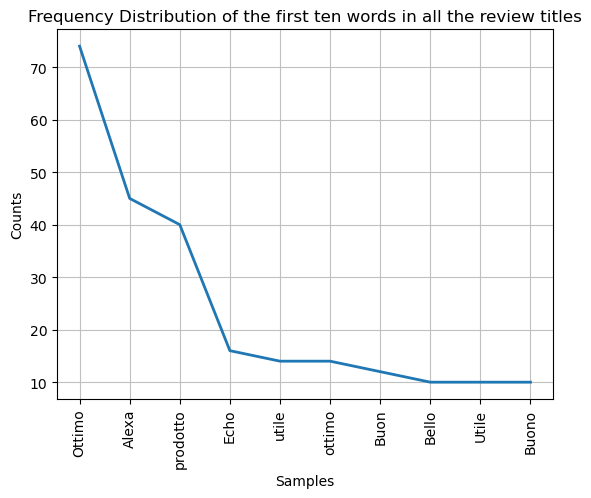

In [7]:
fd_title.plot(10, cumulative=False, title='Frequency Distribution of the first ten words in all the review titles')
plt.show()

In [29]:
list_body = df['Body'].to_list()
list_body = [str(word) for word in list_body]
words_body = [word for text in list_body for word in nltk.word_tokenize(text)]
words_body_clear = [w for w in words_body if w.lower() not in stopwords]
words_body_clear = [char for char in words_body_clear if char.isalpha()]

In [30]:
fd_body = nltk.FreqDist(words_body_clear)
fd_body.tabulate(10)

   Alexa    molto prodotto   musica     casa    audio    suono  qualità   Ottimo    utile 
     112       80       76       75       68       59       59       54       52       48 


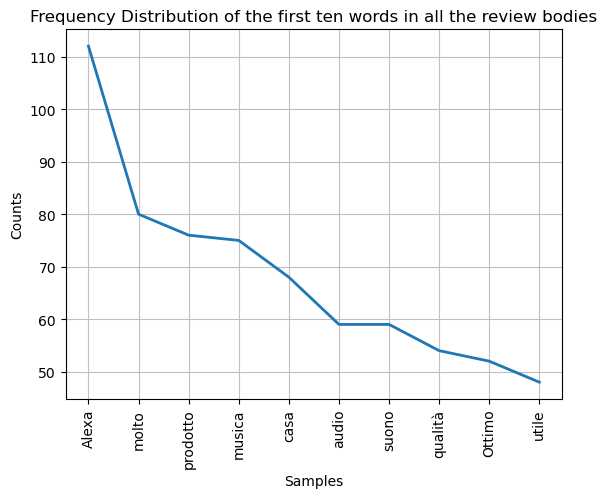

In [31]:
fd_body.plot(10, cumulative=False, title='Frequency Distribution of the first ten words in all the review bodies')
plt.show()

In [46]:
sia = SentimentIntensityAnalyzer()
title_polarity = [sia.polarity_scores(str(element)) for element in df['Title']]
body_polarity = [sia.polarity_scores(str(element)) for element in df['Body']]

In [56]:
title_pol_mean = []

for i in range(len(title_polarity)):
    if title_polarity[i]['compound'] == 0.0:
        title_pol_mean.append(0.5)
    else:
        title_pol_mean.append(title_polarity[i]['compound'])

In [113]:
body_pol_mean = []

for i in range(len(body_polarity)):
    if body_polarity[i]['compound'] == 0.0:
        body_pol_mean.append(0.5)
    else:
        body_pol_mean.append(body_polarity[i]['compound'])

In [114]:
total_polarity = []
total_polarity = [round((i*0.2 + j*0.8)/2, 4) for i,j in zip(title_pol_mean, body_pol_mean)]

In [115]:
df['Polarity'] = total_polarity

In [116]:
for i in range(len(df)):
    if df['Polarity'][i] < 0:
        df['Polarity_Text'][i] = 'Bad'
    else:
        df['Polarity_Text'][i] = 'Good'

/var/folders/qg/gd9h1fz150q_s3t9_v7l4qd80000gn/T/ipykernel_1151/3179715000.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity_Text'][i] = 'Good'
/var/folders/qg/gd9h1fz150q_s3t9_v7l4qd80000gn/T/ipykernel_1151/3179715000.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Polarity_Text'][i] = 'Bad'


In [117]:
df['Polarity_Text'].value_counts()

Good    445
Bad      65
Name: Polarity_Text, dtype: int64

In [ ]:
# Naive Bayes
nb = GaussianNB()
X_train, X_test, Y_train, Y_test = train_test_split()